<a href="https://colab.research.google.com/github/maximponedelchenko/-21-2/blob/main/%D0%9C%D0%B0%D0%BA%D1%81%D0%B8%D0%BC_%D0%9F%D0%BE%D0%BD%D0%B5%D0%B4%D0%B5%D0%BB%D1%8C%D1%87%D0%B5%D0%BD%D0%BA%D0%BE_%D0%9F%D1%80%D0%BE%D0%B5%D0%BA%D1%82.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import pandas as pd
import numpy as np
import yfinance as yf
import requests
import datetime
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import nltk

In [8]:
def get_news():
    url = "https://www.bing.com/news/search?q=Bitcoin&FORM=HDRSC6"  # Новости про Bitcoin
    headers = {"User-Agent": "Mozilla/5.0"}  # Чтоб сайт не заблокировал запрос

    response = requests.get(url, headers=headers)
    if response.status_code != 200:
        print("Ошибка при запросе данных. Код состояния:", response.status_code)
        return []

    try:
        soup = BeautifulSoup(response.text, "html.parser")
        articles = soup.find_all("a", class_="title", limit=10)  # Ищем заголовки
        return [article.text for article in articles]  # Извлекаем текст заголовков
    except Exception as e:
        print("Ошибка при обработке HTML:", e)
        return []

# Проверяем исправленный код
news_articles = get_news()
print("Полученные новости:", news_articles)

Полученные новости: ['Here’s Why the Bitcoin Price Is Stuck Despite ‘Massive Opportunity’', "BlackRock's Global Allocation fund owns $47.4M in Bitcoin ETF, filing shows", 'Bitcoin price rally stalls as gold nears record $3.1K', 'Ripple CEO Issues ‘Massive’ Trillion Dollar Prediction Amid Bitcoin, XRP And Crypto Price Swings', "Should You Buy Bitcoin While It's Under $90,000?", 'McDonald’s memes return as Bitcoin stalls below $86K', 'Trader Michaël van de Poppe Says Bull Market for Chainlink (LINK) Has Started, Updates Outlook on Bitcoin', 'Cryptocurrency Price Today (March 27): Bitcoin Dips Below $88,000, MKR Becomes Top Gainer', 'Bitcoin is just another tech stock, not a market hedge, study shows', 'Bitcoin in the bush - the crypto mine in remote Zambia']


In [9]:
# Загружаем данные для анализа тональности
nltk.download("vader_lexicon")

def analyze_sentiment(news_articles):
    sia = SentimentIntensityAnalyzer()
    sentiment_scores = [sia.polarity_scores(article)["compound"] for article in news_articles]  # Оцениваем каждую новость
    avg_sentiment = np.mean(sentiment_scores) if sentiment_scores else 0  # Среднее значение тональности
    return avg_sentiment

# Анализируем собранные новости
sentiment_score = analyze_sentiment(news_articles)
print(f"Анализ настроений: {sentiment_score:.2f}")

Анализ настроений: -0.00


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [12]:
# Функция для получения исторических данных о Bitcoin
def get_btc_data():
    btc = yf.Ticker("BTC-USD")
    df = btc.history(period="7d", interval="1m")  # Получаем данные за 7 дней с шагом 1 минута
    df.reset_index(inplace=True)
    return df

# Загружаем данные о Bitcoin
btc_data = get_btc_data()

# Формируем признаки для модели (Open, High, Low, Volume)
features = ["Open", "High", "Low", "Volume"]

# Добавляем оценку настроений как новый признак
btc_data["Sentiment"] = sentiment_score  # Используем среднюю оценку настроений

# Целевая переменная - цена закрытия (Close)
target = "Close"

# Разделяем данные на тренировочные и тестовые выборки
X = btc_data[features + ["Sentiment"]]
y = btc_data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Инициализация модели
model = RandomForestRegressor(n_estimators=200, random_state=42)

# Обучаем модель
model.fit(X_train, y_train)

# Оцениваем модель
predictions = model.predict(X_test)
mae = np.mean(np.abs(predictions - y_test))  # Средняя абсолютная ошибка
print(f"Средняя абсолютная ошибка: {mae:.2f} USD")

Средняя абсолютная ошибка: 0.52 USD


In [13]:
def predict_future_price():
    # Используем последние данные для прогнозирования
    last_data = btc_data.iloc[-1][features + ["Sentiment"]].values.reshape(1, -1)

    # Прогнозируем цену через 10 минут
    predicted_price = model.predict(last_data)[0]

    # Выводим результат
    print(f"Прогнозируемая цена Bitcoin через 10 минут: {predicted_price:.2f} USD")

# Прогнозируем цену
predict_future_price()

Прогнозируемая цена Bitcoin через 10 минут: 87076.56 USD


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


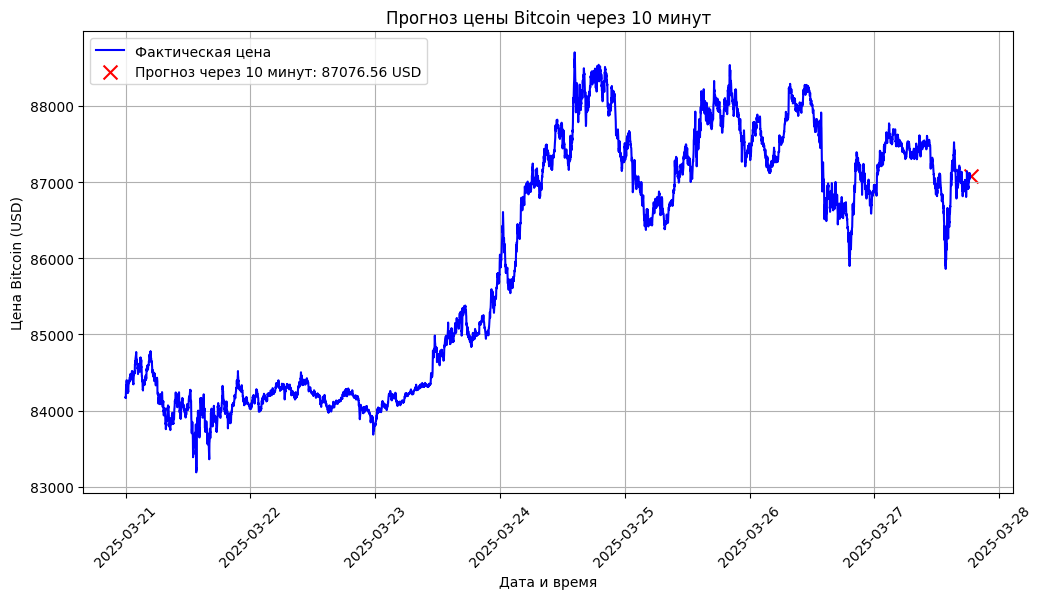

In [22]:
def plot_predictions():
    plt.figure(figsize=(12, 6))

    # График фактических цен
    plt.plot(btc_data.index, btc_data["Close"], label="Фактическая цена", color="blue")

    # Получаем последний временной индекс в формате datetime
    last_time = btc_data.index[-1]

    # Добавим предсказанную цену на график
    predicted_time = last_time + pd.Timedelta(minutes=10)
    predicted_price = model.predict(btc_data.iloc[-1][features + ["Sentiment"]].values.reshape(1, -1))[0]

    plt.scatter(predicted_time, predicted_price, color="red", label=f"Прогноз через 10 минут: {predicted_price:.2f} USD", marker="x", s=100)

    # Настройка графика
    plt.xlabel("Дата и время")
    plt.ylabel("Цена Bitcoin (USD)")
    plt.title("Прогноз цены Bitcoin через 10 минут")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)

    # Показать график
    plt.show()

# Построим график
plot_predictions()